# Takahashi Model Emulation (Python Implementation)

## From (1) Takahashi et al. (1993) Reference. SEPARATION OF LIGHT RARE-EARTH ELEMENTS FROM RARE-EARTH MIXTURE SOLUTION BY USE OF ELECTRODIALYSIS WITH COMPLEXING AGENTS.

### Attempting to solve the following DE for the REE ions $La^{3+}$ and $Nd^{3+}$:

![](diff_eqn_16.png "picture")

__Subscripts: F = feed solution, i = ion species, s = strip solution (aka concentrate solution)__

__Bar notation == in membrane__

__V = volume, C = concentration, S = surface area, J = flux in membrane, z = valence, D = diffusion coefficient, F = Faraday constant, I = current density__ 

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import *
import matplotlib.pyplot as plt
%matplotlib inline
np.seterr(divide='ignore');

<code>Sample initial parameters:</code>

$
\begin{align}
La^{3+} = Nd^{3+} = 10~mol/m^3, && EDTA:REE = 0.5, && pH = 3, && Q = 100~mol/m^3
\end{align}
$


In [2]:
print('Please input the initial parameters for a binary La/Nd w/ EDTA separation: ')

REE_conc = float(input('La and Nd initial concentration (mol/m^3): '))
EDTA_ratio = float(input('EDTA to REE Ratio (0 to 1.0): '))
pH = float(input('Initial pH: '))
Q = float(input('Ion exchange capacity (mol/m^3): '))


Please input the initial parameters for a binary La/Nd w/ EDTA separation: 


La and Nd initial concentration (mol/m^3):  10
EDTA to REE Ratio (0 to 1.0):  0.5
Initial pH:  3
Ion exchange capacity (mol/m^3):  100


In [26]:
initial_concs = [REE_conc, REE_conc, REE_conc*EDTA_ratio, 10**-pH, Q]

C_La_i = initial_concs[0]
C_Nd_i = initial_concs[1]
C_Na_i = initial_concs[2]
C_H_i = initial_concs[3]
Q = initial_concs[4]
    

def eq_79(mem_guess):

    C_La_mem = mem_guess[0]
    C_Nd_mem = mem_guess[1]
    C_Na_mem = mem_guess[2]
    C_H_mem = mem_guess[3]
    
    solution = np.zeros(4) # 4 equations to solve
    
    solution[0] = C_La_mem - (1.49 * np.power(C_H_mem, 3) * (C_La_i/(np.power(C_H_i,3)))**0.8)
    solution[1] = C_Nd_mem - (1.15 * np.power(C_H_mem, 3) * (C_Nd_i/(np.power(C_H_i,3)))**0.8)
    solution[2] = C_Na_mem - (0.32 * C_H_mem * (C_Na_i/C_H_i))
    solution[3] = Q - (3 * (C_La_mem+C_Nd_mem) + C_Na_mem + C_H_mem)
    
    return solution


In [27]:
sample_guess = np.array([17.3, 13.4, 7.81, 0.00488])
sample_guess2 = np.array([1,1,1,1]) # estimate membrane values
eq_79_sol = fsolve(eq_79, sample_guess2)
print(eq_79_sol)

[1.73425316e+01 1.33851753e+01 7.81199681e+00 4.88249801e-03]


In [28]:
#List of constant values.
surface_area = 0.005 
valence = 3
D_La = 4.4e13
D_Nd = 5.2e13
D_Na = 1.9e15
D_H = 1.1e16

C_La_mem0 = eq_79_sol[0] 
C_Nd_mem0 = eq_79_sol[1] 
C_Na_mem0 = eq_79_sol[2]
C_H_mem0 = eq_79_sol[3]

K_H_La = 1.49
K_H_Nd = 1.15
K_H_Na = 0.32

#J_Na = D_Na*C_Na_mem0
#J_H = D_H*C_H_mem0
I = 20
F = 96485
V = 0.00125

# IVP parameters
tspan = [0, 100000]
y0 = [C_La_mem0, C_Nd_mem0, C_Na_mem0, C_H_mem0]


In [29]:
# Dynamics function
def RKG_Takahashi(t, z):
    '''
        z[0] = C_La
        z[1] = C_Nd
        z[2] = C_Na
        z[3] = C_H
        
        f1 = dC_La/dt
        f2 = dC_Nd/dt
        f3 = dC_Na/dt
        f4 = dC_H/dt
        
        ** Need to convert f5-f8 into an array**
    '''
    ## solve the equations 7-9 simultaneously here prior to the four DEs
    
    C_La_mem, C_Nd_mem, C_Na_mem, C_H_mem = z # initial values
    
    f1 = surface_area * ((valence * D_La * C_La_mem) / (valence**2 * D_La * C_La_mem + valence**2 * D_Nd * C_Nd_mem + D_Na * C_Na_mem + D_H * C_H_mem)) * I/F * 1/-V
    f2 = surface_area * ((valence * D_Nd * C_Nd_mem) / (valence**2 * D_Nd * C_Nd_mem + valence**2 * D_La * C_La_mem + D_Na * C_Na_mem + D_H * C_H_mem)) * I/F * 1/-V
    f3 = surface_area * ((D_Na * C_Na_mem) / (valence**2 * D_La * C_La_mem + valence**2 * D_Nd * C_Nd_mem + D_Na * C_Na_mem + D_H * C_H_mem)) * I/F * 1/-V
    f4 = surface_area * ((D_H * C_H_mem) / (valence**2 * D_La * C_La_mem + valence**2 * D_Nd * C_Nd_mem + D_Na * C_Na_mem + D_H * C_H_mem)) * I/F * 1/-V
     
    return [f1, f2, f3, f4]

In [30]:
sol = solve_ivp(RKG_Takahashi, tspan, y0, method='RK45', t_eval = np.linspace(0, 21600, 30))

In [31]:
type(sol)

scipy.integrate._ivp.ivp.OdeResult

In [32]:
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 362
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([    0.        ,   744.82758621,  1489.65517241,  2234.48275862,
        2979.31034483,  3724.13793103,  4468.96551724,  5213.79310345,
        5958.62068966,  6703.44827586,  7448.27586207,  8193.10344828,
        8937.93103448,  9682.75862069, 10427.5862069 , 11172.4137931 ,
       11917.24137931, 12662.06896552, 13406.89655172, 14151.72413793,
       14896.55172414, 15641.37931034, 16386.20689655, 17131.03448276,
       17875.86206897, 18620.68965517, 19365.51724138, 20110.34482759,
       20855.17241379, 21600.        ])
 t_events: None
        y: array([[ 1.73425316e+01,  1.72915527e+01,  1.72394789e+01,
         1.71862841e+01,  1.71319418e+01,  1.70764260e+01,
         1.70197106e+01,  1.69617688e+01,  1.69025744e+01,
         1.68421023e+01,  1.67803281e+01,  1.67172276e+01,
         1.66527782e+

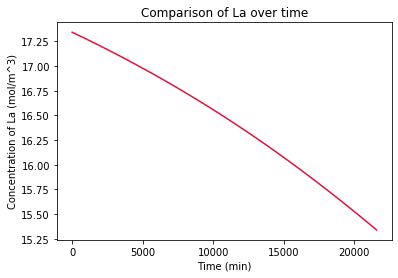

In [33]:
# La solution
plt.plot(sol.t, sol.y[0], 'crimson');
plt.title('Comparison of La over time')
plt.xlabel('Time (min)')
plt.ylabel('Concentration of La (mol/m^3)');

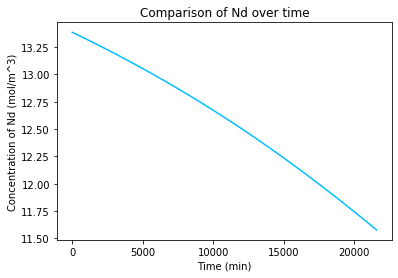

In [34]:
# Nd Solution
plt.plot(sol.t, sol.y[1], color='deepskyblue');
plt.title('Comparison of Nd over time')
plt.xlabel('Time (min)')
plt.ylabel('Concentration of Nd (mol/m^3)');

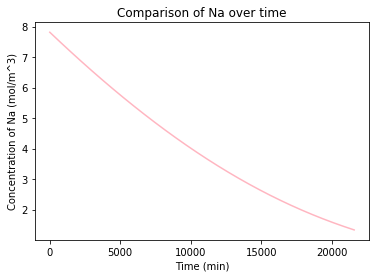

In [35]:
# Na Solution
plt.plot(sol.t, sol.y[2], color='lightpink');
plt.title('Comparison of Na over time')
plt.xlabel('Time (min)')
plt.ylabel('Concentration of Na (mol/m^3)');

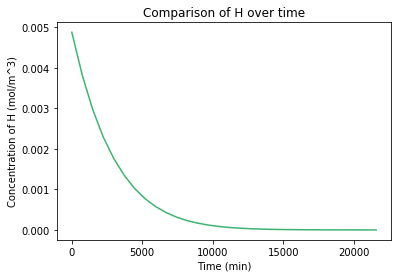

In [36]:
# H Solution
plt.plot(sol.t, sol.y[3], color='mediumseagreen');
plt.title('Comparison of H over time')
plt.xlabel('Time (min)')
plt.ylabel('Concentration of H (mol/m^3)');

![](model_pdf.PNG "picture")